In [11]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

import pandas as pd


In [12]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [13]:
#add back the description of the proteins
desc_dict = {}
path = 'TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc


In [14]:
#get glycosome data
ref_df = pd.read_csv('glycosome_experiment_extended.txt',sep='\t')    
ref_df['[Ortholog Group]']=ref_df['[Ortholog Group]'].astype('category')
ref_df['ortho_codes']=ref_df['[Ortholog Group]'].cat.codes
ref_df['[Input ID]']=[n.replace(' ','') for n in ref_df['[Input ID]']]
ref_df.set_index('[Input ID]',inplace=True)  
#print (ref_df.head())

lucia_experiments = pd.read_table('glycosome_experiment.txt',sep='\t')
lucia_experiments['[Input ID]']=lucia_experiments['GeneDB IDs']
lucia_experiments['[Input ID]']=[n.replace(' ','') for n in lucia_experiments['[Input ID]']]
lucia_experiments.set_index('[Input ID]',inplace=True)
#print (lucia_experiments.head())


ref_df = ref_df.join(lucia_experiments,how='left')
ref_df.drop_duplicates(subset=['[Gene ID]'],inplace=True)
ref_df.set_index('[Gene ID]',inplace=True,drop=True)
ref_df=ref_df[['Log2 H/L','Log10 (Int H*L)','Group', 'Glycosome status ']]
ref_df.head()

,Log2 H/L,Log10 (Int H*L),Group,Glycosome status
[Gene ID],,,,
Tb06.3A7.270,-0.113504,11.743189,i,red
Tb927.9.1350,0.020373,13.847976,i,red
Tb927.9.1360,0.034075,11.430029,i,red
Tb927.9.1380,0.158678,12.763610,i,red
Tb927.9.1410,0.002214,13.992089,i,red


In [15]:
df = pd.read_csv('proteinGroups.txt',sep='\t')
df = clean(df)
df['Gene_id'] = [clean_id(n.split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df.set_index('Gene_id',inplace=True)
df=df.join(ref_df,how='left')


tm = pd.read_csv('GeneByLocusTag_Summary.txt',sep='\t')
tm.drop_duplicates(subset=['[Input ID]'],inplace=True)
tm.set_index('[Input ID]',inplace=True)


df = df.join(tm, how='left')
df['[SignalP Peptide]'] = [1 if str(n) != 'nan' else 0 for n in df['[SignalP Peptide]'] ] 

removed  68 Only identified by site
tot  68  entries removed
---------------
removed  8 Reverse
tot  76  entries removed
---------------
removed  30 Potential contaminant
tot  106  entries removed
---------------


In [16]:
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Group,Glycosome status,[Gene ID],[source_id],[Genomic Location (Gene)],[Product Description],[# TM Domains],[SignalP Peptide],[SignalP Scores],Unnamed: 8
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4380,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,1;1,1;1,1;1,Tb927.5.4380:mRNA-p1 | transcript=Tb927.5.4380...,2,1,1,1,...,i,red,Tb927.5.4380,Tb927.5.4380:mRNA,"Tb927_05_v5.1:1,357,568..1,362,572(-)",kinetoplastid-specific phospho-protein phospha...,0.0,0,NaN,NaN
Tb06.3A7.270,Tb06.3A7.270:mRNA-p1,Tb06.3A7.270:mRNA-p1,3,3,3,Tb06.3A7.270:mRNA-p1 | transcript=Tb06.3A7.270...,1,3,3,3,...,i,red,Tb06.3A7.270,Tb06.3A7.270:mRNA,"Tb927_06_v5.1:389,986..393,393(-)","hypothetical protein, conserved",0.0,0,NaN,NaN
Tb927.10.4440,Tb927.10.4440:mRNA-p1;Tb10.v4.0034:mRNA-p1,Tb927.10.4440:mRNA-p1;Tb10.v4.0034:mRNA-p1,1;1,1;1,1;1,Tb927.10.4440:mRNA-p1 | transcript=Tb927.10.44...,2,1,1,1,...,i,red,Tb927.10.4440,Tb927.10.4440:mRNA,"Tb927_10_v5.1:1,143,481..1,144,823(-)",predicted SAP domain protein,0.0,0,NaN,NaN
Tb927.10.4330,Tb927.10.4330:mRNA-p1;Tb11.v5.1012.1-p1;Tb10.v...,Tb927.10.4330:mRNA-p1;Tb11.v5.1012.1-p1;Tb10.v...,3;3;3,3;3;3,3;3;3,Tb927.10.4330:mRNA-p1 | transcript=Tb927.10.43...,3,3,3,3,...,i,red,Tb927.10.4330,Tb927.10.4330:mRNA,"Tb927_10_v5.1:1,125,350..1,126,618(+)","2-oxoisovalerate dehydrogenase beta subunit, m...",0.0,0,NaN,NaN
Tb927.10.4310,Tb927.10.4310:mRNA-p1;Tb10.v4.0045:mRNA-p1,Tb927.10.4310:mRNA-p1;Tb10.v4.0045:mRNA-p1,10;10,10;10,10;10,Tb927.10.4310:mRNA-p1 | transcript=Tb927.10.43...,2,10,10,10,...,i,red,Tb927.10.4310,Tb927.10.4310:mRNA,"Tb927_10_v5.1:1,121,038..1,122,325(+)","prohibitin 2, putative",1.0,0,NaN,NaN


In [17]:
df['fc']= df['Intensity 1']/df['Intensity']
df['signal_perc']    =  df['Intensity 1'] / (df['Intensity 1']+df['Intensity 2'])*100
df['fc2']= df['iBAQ 1']/df['iBAQ']
df['log10_score'] = np.log10(df['Score'])
df[['Gene_desc','fc','fc2']].sort_values('fc', ascending=False).head(5)

,Gene_desc,fc,fc2
Gene_id,,,
Tb927.10.8070,"ATPase, putative",1.0,1.0
Tb927.10.11300,"paraflagellar rod component, putative",1.0,1.0
Tb927.10.3640,"nuclear transmembrane protein, putative",1.0,1.0
Tb927.11.12930,"DEAD-box helicase, putative",1.0,1.0
Tb927.4.3700,"hypothetical protein, conserved",1.0,1.0


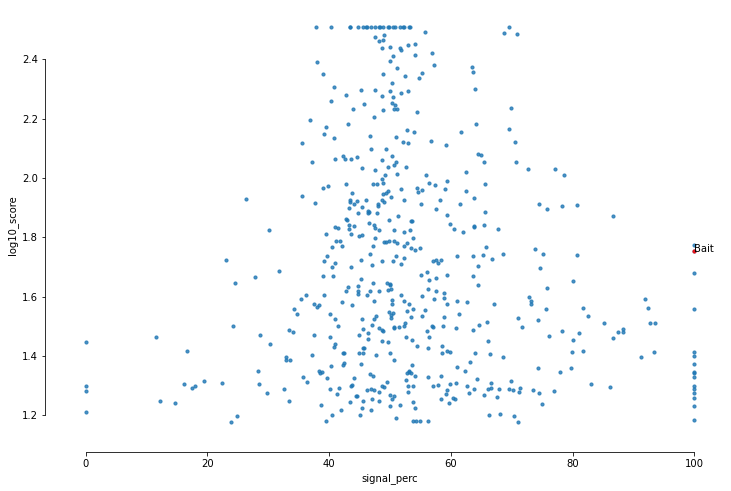

In [20]:
selection = df[df['Score']>15]
fig,ax = plt.subplots(figsize=(12,8))
sns.regplot(x='signal_perc', y='log10_score', 
            fit_reg=False, data = selection,
            ax=ax, scatter_kws={'s':10})
sns.despine(offset=10, trim=True)
sns.regplot(x='signal_perc', y='log10_score', 
            fit_reg=False, data = selection.loc[['Tb927.11.12080',
                                                 #'Tb927.10.9860',
                                                 #'Tb927.11.15990',
                                                #'Tb927.10.7100',
                                                #'Tb927.11.12500'
                                                ]],
            ax=ax, scatter_kws={'s':10,'color':'red'})


x = selection.loc[['Tb927.11.12080']]['signal_perc']
y= selection.loc[['Tb927.11.12080']]['log10_score']
ax.annotate('Bait',(x,y), xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.9860']]['fc']
#y= selection.loc[['Tb927.10.9860']]['log10_score']
#ax.annotate('MTQ1, putative',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.15990']]['fc']
#y= selection.loc[['Tb927.11.15990']]['log10_score']
#ax.annotate('NUP109',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.10.7100']]['fc']
#y= selection.loc[['Tb927.10.7100']]['log10_score']
#ax.annotate('Tb927.10.7100',(x,y),xytext=(x+0.01,y))

#x = selection.loc[['Tb927.11.12500']]['fc']
#y= selection.loc[['Tb927.11.12500']]['log10_score']
#ax.annotate('Tb927.11.12500',(x,y),xytext=(x+0.01,y))




#ax.set_xlabel('Sum Intensity / Bait Intensity')
#ax.set_ylabel('Log10 Score')
plt.savefig('Fig1.svg')
plt.show()

In [9]:
#interactive plot

trace_1 = go.Scatter(
    x=selection.fc,
    y=selection.log10_score,
    mode='markers',
    name='MA Plot',
    text = [a + ' ' +b for a,b in zip(selection.index.values, selection.Gene_desc)],
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = selection.fc2, #set color equal to a variable
        colorscale='Bluered',
        showscale=True
    )
)
'''
annot_1 = go.Scatter(
    x=[selection.fc.loc['Tb927.3.2610']],
    y=[selection.log10_score.loc['Tb927.3.2610']],
    mode='markers+text',
    name='Tb927.3.2610',
    text=['Bait'],
    textposition='bottom center'
)

annot_1 = go.Scatter(
    x=[selection.fc.loc['Tb927.11.11750']],
    y=[selection.log10_score.loc['Tb927.11.11750']],
    mode='markers+text',
    name='Tb927.11.11750',
    text=['membrane-bound acid phosphatase, putative'],
    textposition='bottom center'
)
'''

layout = dict(title='Crosslinker Experiment')


fig = go.Figure(data=[trace_1], 
                layout=layout)
iplot(fig, filename='test')

In [10]:
def parse_phobius(in_file='../phobius_prediction.txt'):
    res_prot = []
    res_counts = []
    count = 0
    for l in open(in_file):
        if l.startswith('ID'):
            res_prot.append(l.split()[-1].strip())
        if 'TRANSMEM' in l:
            count+=1
        if l.startswith('//'):
            res_counts.append(count)
            count=0
    return res_prot,res_counts
        
res_prot,res_counts=parse_phobius(in_file='../20180820 TbdeAc2 labeel free data-1/phobius_prediction.txt') 
print (len(res_prot),len(res_counts))
tm_count_dict = dict(zip(res_prot,res_counts))
print (tm_count_dict['Tb927.3.2610'])

11567 11567
11


In [11]:
phobius_df = pd.DataFrame()
phobius_df['Gene_ids']=res_prot
phobius_df['TM count']=res_counts
phobius_df.set_index('Gene_ids',inplace=True)

In [12]:
import re
motif_list = [ 'G.S.G', 'G.SGS', 'GDSL', 'GDSA', 'HD..Y', 'Y.G.G', 'HD', 'HE']
motif_list = [re.compile(n) for  n in motif_list]

In [13]:
#add back the description of the proteins
motif_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        temp_res = []
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_seq = str(record.seq)
        for item in motif_list:
            temp_res.append(len(item.findall(temp_seq)))
        motif_dict[temp_id]=temp_res        

In [14]:
motif_dict_df = pd.DataFrame(motif_dict).T
motif_dict_df.columns = ['G.S.G', 'G.SGS', 'GDSL', 'GDSA', 'HD..Y', 'Y.G.G', 'HD', 'HE']
motif_dict_df.head()

,G.S.G,G.SGS,GDSL,GDSA,HD..Y,Y.G.G,HD,HE
Tb427.BES40.22,0,0,0,0,0,0,1,1
Tb927.1.05,0,0,0,0,0,0,1,0
Tb927.1.1000,0,0,0,0,0,0,0,0
Tb927.1.100,0,0,0,0,0,0,0,2
Tb927.1.1010,0,0,0,0,0,0,0,0


In [15]:
df=df.join(phobius_df, how='left')

In [16]:
df.to_csv('out.csv')

In [17]:

#read data and log transform for plots
df2 = pd.read_csv('../proteinGroups.txt',sep='\t')
df2 = clean(df2)
df2.head()

df2['Gene_id'] = [clean_id(n.split(';')[0]) for n in df2['Protein IDs']]
df2['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df2['Gene_id']]


df2['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df2['Protein IDs' ]  ]  
df2['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df2['Gene_id_all' ]  ]  

df2['logInt']=np.log10(df2['Intensity'])
df2['logRatio']=np.log2(df2['Ratio H/L normalized'])
df2['logScore']=np.log10(df2['Score'])
df2.head()

removed  52 Only identified by site
tot  52  entries removed
---------------
removed  20 Reverse
tot  72  entries removed
---------------
removed  29 Potential contaminant
tot  101  entries removed
---------------


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_id,Gene_desc,Gene_id_all,Gene_desc_all,logInt,logRatio,logScore
58,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,10;10;5,10;10;5,10;10;5,;;,3,10,10,10,...,584;2679;3663;4909;5238;5244;9265;10971;15238;...,NaN,NaN,Tb927.5.4460,"major vault protein, putative",Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",7.157003,-0.369334,1.636638
59,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,Tb927.5.4480:mRNA-p1;Tb05.5K5.130:mRNA-p1,1;1,1;1,1;1,;,2,1,1,1,...,2821,NaN,NaN,Tb927.5.4480,"paraflagellar rod component par4, putative",Tb927.5.4480;Tb05.5K5.130,"paraflagellar rod component par4, putative; pa...",5.312643,NaN,0.631363
60,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,2;2,2;2,2;2,;,2,2,2,2,...,7603;15454,NaN,NaN,Tb927.5.4500,"ras-like small GTPase, putative",Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",5.540455,-0.198146,0.887938
61,Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1,Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1,1;1,1;1,1;1,;,2,1,1,1,...,16138,NaN,NaN,Tb927.5.4520,Kinetochore interacting protein 1,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,5.998303,NaN,0.504294
62,Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1,Tb927.5.4360:mRNA-p1;Tb05.5K5.20:mRNA-p1,2;2,2;2,2;2,;,2,2,2,2,...,9397;12919,NaN,NaN,Tb927.5.4360,"hypothetical protein, conserved",Tb927.5.4360;Tb05.5K5.20,"hypothetical protein, conserved; hypothetical ...",5.142921,NaN,0.658126


In [18]:
#select some fielsd from the full output
selection = df2[['Gene_id','Gene_desc', 'Score', 
                'Ratio H/L normalized', 'Intensity', 
                'logInt', 'logRatio','logScore']]
selection.dropna(inplace=True)
selection.sort_values('logRatio',inplace=True,ascending =False)
selection.to_csv('silac_clean.csv')
selection.head()

,Gene_id,Gene_desc,Score,Ratio H/L normalized,Intensity,logInt,logRatio,logScore
1054,Tb927.11.9400,"hypothetical protein, conserved",4.7487,21.2700,1061800,6.026043,4.410748,0.676575
1424,Tb927.5.1210,"short-chain dehydrogenase, putative",102.8800,13.6010,47788000,7.679319,3.765641,2.012331
695,Tb927.11.12080,N-acetyl-D-glucosaminylphosphatidylinositol de...,29.8040,13.2970,3156700,6.499233,3.733029,1.474275
968,Tb927.11.6210,Lanosterol 14-alpha demethylase,4.3205,12.7250,4638000,6.666331,3.669594,0.635534
497,Tb927.10.4040,3-keto-dihydrosphingosine reductase,6.3210,9.7405,1800500,6.255393,3.283996,0.800786


In [19]:
df_merge=df.merge(selection,on='Gene_id',how='outer')

In [20]:
df_merge.head()

,Gene_id,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,...,fc2,log10_score,TM count,Gene_desc_y,Score_y,Ratio H/L normalized,Intensity_y,logInt,logRatio,logScore
0,Tb927.5.4380,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,Tb927.5.4380:mRNA-p1;Tb05.5K5.30:mRNA-p1,1;1,1;1,1;1,Tb927.5.4380:mRNA-p1 | transcript=Tb927.5.4380...,2.0,1.0,1.0,...,0.478290,0.891186,0.0,kinetoplastid-specific phospho-protein phospha...,95.5120,1.01280,4443600.0,6.647735,0.018349,1.980058
1,Tb06.3A7.270,Tb06.3A7.270:mRNA-p1,Tb06.3A7.270:mRNA-p1,3,3,3,Tb06.3A7.270:mRNA-p1 | transcript=Tb06.3A7.270...,1.0,3.0,3.0,...,0.535331,1.342107,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tb927.10.4440,Tb927.10.4440:mRNA-p1;Tb10.v4.0034:mRNA-p1,Tb927.10.4440:mRNA-p1;Tb10.v4.0034:mRNA-p1,1;1,1;1,1;1,Tb927.10.4440:mRNA-p1 | transcript=Tb927.10.44...,2.0,1.0,1.0,...,1.000000,0.840345,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tb927.10.4330,Tb927.10.4330:mRNA-p1;Tb11.v5.1012.1-p1;Tb10.v...,Tb927.10.4330:mRNA-p1;Tb11.v5.1012.1-p1;Tb10.v...,3;3;3,3;3;3,3;3;3,Tb927.10.4330:mRNA-p1 | transcript=Tb927.10.43...,3.0,3.0,3.0,...,0.477675,1.401693,0.0,"2-oxoisovalerate dehydrogenase beta subunit, m...",9.8947,0.74116,703290.0,5.847134,-0.432143,0.995403
4,Tb927.10.4310,Tb927.10.4310:mRNA-p1;Tb10.v4.0045:mRNA-p1,Tb927.10.4310:mRNA-p1;Tb10.v4.0045:mRNA-p1,10;10,10;10,10;10,Tb927.10.4310:mRNA-p1 | transcript=Tb927.10.43...,2.0,10.0,10.0,...,0.464438,1.888219,1.0,"prohibitin 2, putative",26.9550,1.13140,10596000.0,7.025142,0.178109,1.430639


In [21]:
df_merge.to_csv('merge.csv')

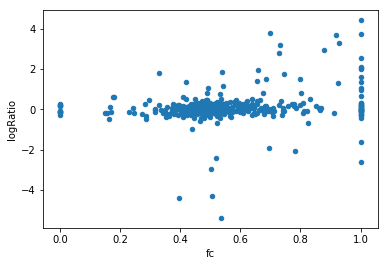

In [22]:
df_merge.plot(kind='scatter', x='fc', y='logRatio')